In [1]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch

from PIL import Image
from transform_factory import resize_322, center_crop_224, imagenet_normalize, tensorize, get_spatial_transform, get_color_transform
from torchvision import transforms
from expl import ExplFactory
from captum.attr import visualization as viz
from torchvision.models import resnet50, ResNet50_Weights
from captum.attr import LayerAttribution

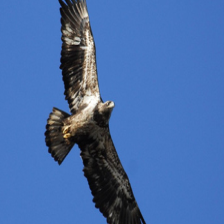

In [4]:
# orig_img_path = "/home/juhyeon/Imagenet/train/n02100236/n02100236_18.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/train/n01443537/n01443537_605.JPEG"
orig_img_path = "/home/juhyeon/Imagenet/train/n01614925/n01614925_13.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/train/n02100236/n02100236_390.JPEG"

model = resnet50(weights = ResNet50_Weights.DEFAULT).eval().cuda()


orig_img = Image.open(orig_img_path)
_orig_img = tensorize(resize_322(orig_img)).unsqueeze(0).cuda()

expl_method = "LayerDL"
expl_func = ExplFactory().get_explainer(model = model, expl_method = expl_method)

center_crop_224(resize_322(orig_img))


tensor([[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        ...,
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0

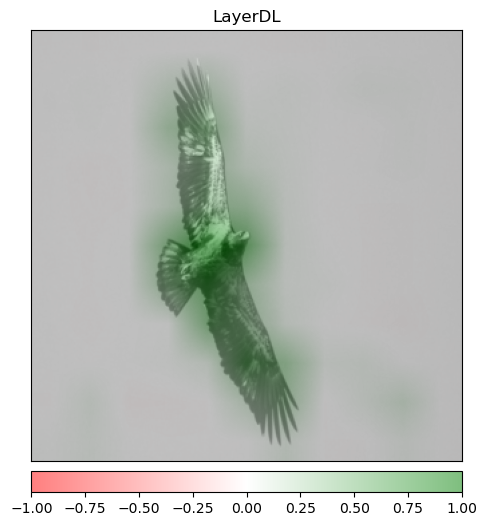

In [5]:
attr, _ = expl_func(_orig_img, "init")
print(attr[0, 0, :, :])
attr = LayerAttribution.interpolate(attr, _orig_img.shape[2:], 'bilinear')
print(attr[0, 0, :, :])

attr = np.transpose(attr.squeeze(0).cpu().detach().numpy(), (1,2,0))

# print(attr)
# plt.imshow(attr, cmap="seismic")
# plt.colorbar()
# plt.show()
# print(attr.shape)
# print(torch.sum(attr))
# plt.imshow(attr)
# plt.colorbar()
# sttr = (attr - torch.min(attr)) / (torch.max(attr) - torch.min(attr))

# rint(attr)
_ = viz.visualize_image_attr(attr, np.transpose(_orig_img.squeeze().cpu().detach().numpy(), (1,2,0)), method="blended_heat_map", sign = 'all', show_colorbar=True, title = expl_method)